<a href="https://colab.research.google.com/github/gabrieltanod/Thesis---CLIP-Based-One-Class-Learning/blob/main/thesis_one_class_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# # 1. Install OpenAI CLIP (safe)
# !pip install git+https://github.com/openai/CLIP.git

# # 2. Install Facenet-PyTorch WITHOUT dependencies
# # This prevents it from uninstalling your GPU-enabled PyTorch
# !pip install facenet-pytorch --no-deps

# # 3. Verify imports immediately to catch errors early
# import torch
# import clip
# from facenet_pytorch import MTCNN

# print(f"✅ PyTorch Version: {torch.__version__}")
# print(f"✅ CUDA Available: {torch.cuda.is_available()}")
# if torch.cuda.is_available():
#     print(f"   GPU: {torch.cuda.get_device_name(0)}")
# else:
#     print("❌ WARNING: You are running on CPU! Enable 'GPU T4 x2' in Accelerator settings.")

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
# Use the Augmented Features from Notebook 1
PATH_REAL_FEATURES = "/content/ffhq_features_augmented.pt"
PATH_FAKE_FEATURES = "/content/test_fake_dalle.pt"

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 50
ALPHA = 0.5 # Weighting factor (0.5 = Equal weight to SVDD and Recon)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running on: {DEVICE}")

Running on: cuda


In [7]:
import os
print(f"File size: {os.path.getsize(PATH_REAL_FEATURES) / 1024 / 1024:.2f} MB")


File size: 152.32 MB


In [8]:
# --- 1. THE HYBRID MODEL ---
class HybridOneClassModel(nn.Module):
    def __init__(self, input_dim=768, svdd_latent=64, recon_hidden=384):
        super(HybridOneClassModel, self).__init__()

        # HEAD 1: Deep SVDD (Compresses to compact manifold)
        self.svdd_encoder = nn.Sequential(
            nn.Linear(input_dim, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, svdd_latent, bias=False)
        )

        # HEAD 2: Reconstruction (Shallow Decoder: 768 -> Hidden -> 768)
        # As per thesis: "Shallow decoder" to learn real feature correlations
        self.reconstructor = nn.Sequential(
            nn.Linear(input_dim, recon_hidden),
            nn.ReLU(),
            nn.Linear(recon_hidden, recon_hidden),
            nn.ReLU(),
            nn.Linear(recon_hidden, input_dim) # Output matches input (z_hat)
        )

    def forward(self, x):
        # Path A: SVDD Projection
        z_svdd = self.svdd_encoder(x)

        # Path B: Reconstruction
        z_hat = self.reconstructor(x)

        return z_svdd, z_hat

In [9]:
# --- 2. THE TRAINER ---
class HybridTrainer:
    def __init__(self, model, center, optimizer, alpha=0.5):
        self.model = model
        self.center = center.detach() # Fixed center c
        self.optimizer = optimizer
        self.alpha = alpha

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        loss_svdd_log = 0
        loss_recon_log = 0

        for batch in dataloader:
            x = batch[0].to(DEVICE)

            self.optimizer.zero_grad()
            z_svdd, z_hat = self.model(x)

            # --- LOSS CALCULATION ---
            # 1. SVDD Loss: Distance to center ||z_svdd - c||^2
            loss_svdd = torch.mean(torch.sum((z_svdd - self.center) ** 2, dim=1))

            # 2. Reconstruction Loss: ||x - x_hat||^2
            loss_recon = torch.mean(torch.sum((x - z_hat) ** 2, dim=1))

            # Combined Loss
            loss = loss_svdd + loss_recon

            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            loss_svdd_log += loss_svdd.item()
            loss_recon_log += loss_recon.item()

        return total_loss / len(dataloader), loss_svdd_log / len(dataloader), loss_recon_log / len(dataloader)


In [10]:
# --- 3. UTILS ---
def init_center_c(model, dataloader):
    """Initialize SVDD center c from the mean of initial pass."""
    print("Initializing center c...")
    model.eval()
    vectors = []
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(DEVICE)
            z_svdd, _ = model(x) # Only care about SVDD head for center
            vectors.append(z_svdd)

    c = torch.mean(torch.cat(vectors), dim=0)
    # Prevent collapse to zero
    c[(abs(c) < 0.1) & (c < 0)] = -0.1
    c[(abs(c) < 0.1) & (c > 0)] = 0.1
    return c

def get_anomaly_score(model, x, c, alpha):
    """Computes s = alpha * ||z-c||^2 + (1-alpha) * ||x - x_hat||^2"""
    z_svdd, z_hat = model(x)

    # Score 1: SVDD Distance
    score_svdd = torch.sum((z_svdd - c)**2, dim=1)

    # Score 2: Reconstruction Error
    score_recon = torch.sum((x - z_hat)**2, dim=1)

    # Combined Score
    return (alpha * score_svdd) + ((1 - alpha) * score_recon)


In [11]:
def run_experiment():
    # --- A. DATA LOADING & SPLITTING ---
    print("Loading Features...")
    # Load Real Data (FFHQ)
    full_real_tensor = torch.load(PATH_REAL_FEATURES, weights_only=False).float()

    # 80/20 Split: 80% for Training/Val, 20% reserved for Final Testing
    total_count = len(full_real_tensor)
    train_val_size = int(0.8 * total_count)
    test_real_size = total_count - train_val_size

    train_val_data, test_real_data = random_split(
        TensorDataset(full_real_tensor), [train_val_size, test_real_size]
    )

    # Further split Train/Val (90% Train, 10% Val for Thresholding)
    train_size = int(0.9 * len(train_val_data))
    val_size = len(train_val_data) - train_size
    train_data, val_data = random_split(train_val_data, [train_size, val_size])

    # Load Fake Data (Used ONLY for Testing)
    fake_tensor = torch.load(PATH_FAKE_FEATURES, weights_only=False).float()

    print(f"SPLIT -> Train: {len(train_data)} | Val: {len(val_data)} | Test Real: {len(test_real_data)} | Test Fake: {len(fake_tensor)}")

    # Create Dataloaders
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

    # --- B. TRAINING ---
    model = HybridOneClassModel().to(DEVICE)
    c = init_center_c(model, train_loader) # Initialize Center
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("\nStarting Training (One-Class Learning)...")
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in train_loader:
            x = batch[0].to(DEVICE)
            optimizer.zero_grad()

            z_svdd, z_hat = model(x)

            # Loss = SVDD Distance + Reconstruction Error
            loss_svdd = torch.mean(torch.sum((z_svdd - c) ** 2, dim=1))
            loss_recon = torch.mean(torch.sum((x - z_hat) ** 2, dim=1))
            loss = loss_svdd + loss_recon

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss/len(train_loader):.4f}")

    # --- C. THRESHOLDING (Validation Phase) ---
    # Thesis: "Thresholded at validation FAR=5%"
    print("\nCalculating Threshold (FAR=5%)...")
    model.eval()
    val_scores = []
    with torch.no_grad():
        for batch in val_loader:
            s = get_anomaly_score(model, batch[0].to(DEVICE), c, ALPHA)
            val_scores.append(s.cpu())
    val_scores = torch.cat(val_scores).numpy()

    # 95th Percentile: 95% of real images are below this score.
    # Any score higher than this is flagged as Fake.
    threshold = np.percentile(val_scores, 95)
    print(f" learned Threshold: {threshold:.4f}")

    # --- D. FINAL TESTING (Inference) ---
    print("\nRunning Final Inference...")

    # 1. Score Real Test Set
    test_real_scores = []
    with torch.no_grad():
        for batch in DataLoader(test_real_data, batch_size=BATCH_SIZE):
            s = get_anomaly_score(model, batch[0].to(DEVICE), c, ALPHA)
            test_real_scores.append(s.cpu())
    test_real_scores = torch.cat(test_real_scores).numpy()

    # 2. Score Fake Test Set
    fake_scores = []
    with torch.no_grad():
        for batch in DataLoader(TensorDataset(fake_tensor), batch_size=BATCH_SIZE):
            s = get_anomaly_score(model, batch[0].to(DEVICE), c, ALPHA)
            fake_scores.append(s.cpu())
    fake_scores = torch.cat(fake_scores).numpy()

    # 3. Calculate AUC
    y_true = [0] * len(test_real_scores) + [1] * len(fake_scores)
    y_scores = np.concatenate([test_real_scores, fake_scores])
    auc = roc_auc_score(y_true, y_scores)

    print(f"\n🎯 FINAL RESULT (AUC): {auc:.4f}")

    # 4. Plot
    plt.figure(figsize=(10,5))
    plt.hist(test_real_scores, bins=50, alpha=0.7, label='Real (Test)')
    plt.hist(fake_scores, bins=50, alpha=0.7, label='Fake (OOD)')
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold (FAR=5%)')
    plt.title(f"Detection Performance (AUC={auc:.4f})")
    plt.xlabel("Anomaly Score (Higher = More Likely Fake)")
    plt.legend()
    plt.show()

    # --- RETURN VARIABLES SO WE CAN USE THEM LATER ---
    return model, c, test_real_scores

Loading Features...
SPLIT -> Train: 74866 | Val: 8319 | Test Real: 20797 | Test Fake: 9621
Initializing center c...

Starting Training (One-Class Learning)...
Epoch 0: Loss = 1.5075
Epoch 5: Loss = 0.0788
Epoch 10: Loss = 0.0447
Epoch 15: Loss = 0.0346
Epoch 20: Loss = 0.0302
Epoch 25: Loss = 0.0278
Epoch 30: Loss = 0.0265
Epoch 35: Loss = 0.0256
Epoch 40: Loss = 0.0251
Epoch 45: Loss = 0.0247

Calculating Threshold (FAR=5%)...
 learned Threshold: 0.0262

Running Final Inference...

🎯 FINAL RESULT (AUC): 0.9464


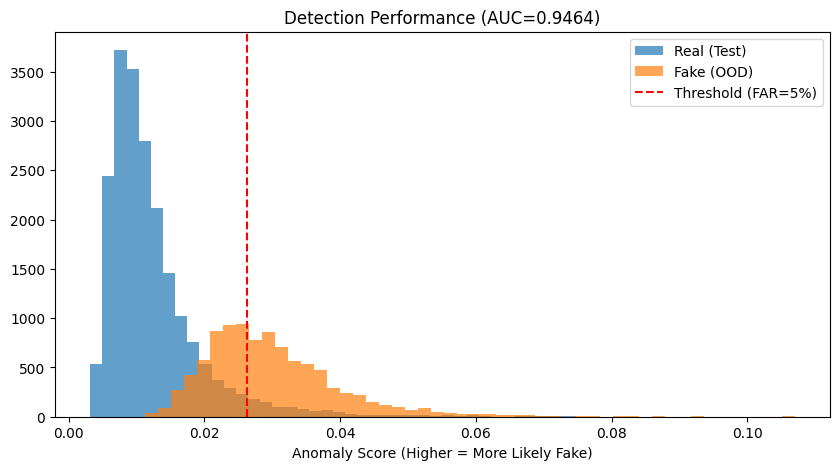

In [12]:
if __name__ == "__main__":
    # Capture the trained model, center, and real scores
    model, c, test_real_scores = run_experiment()

⚡ STARTING VISUAL STRESS TEST ON 3 DATASETS

--- Processing: DALL-E (GenImage) ---
   👉 AUC: 0.9464


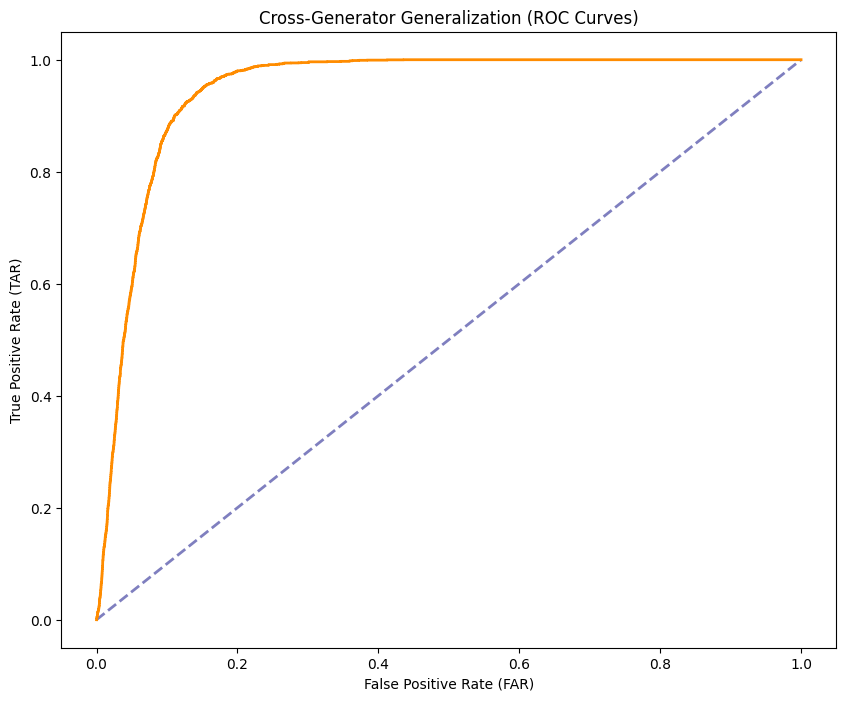

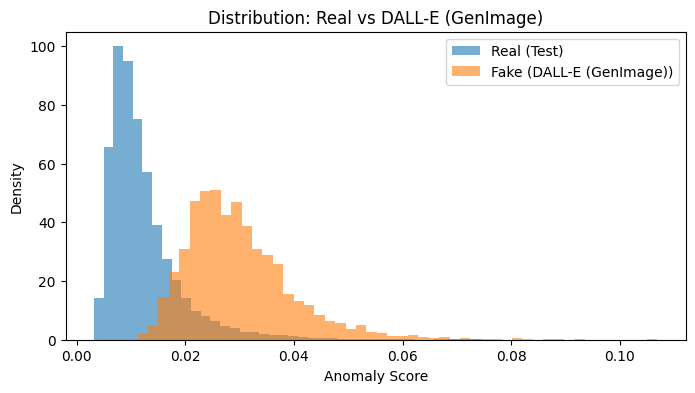

--- Processing: Stable Diffusion ---
   👉 AUC: 0.8573


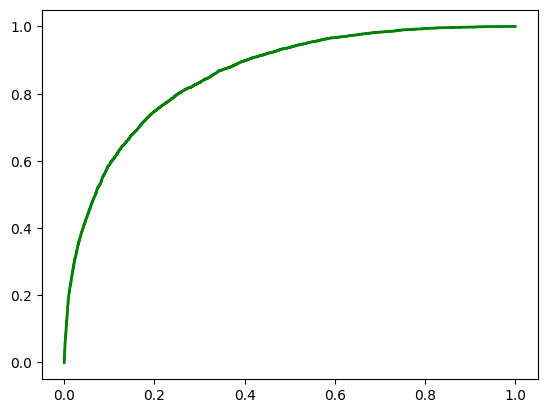

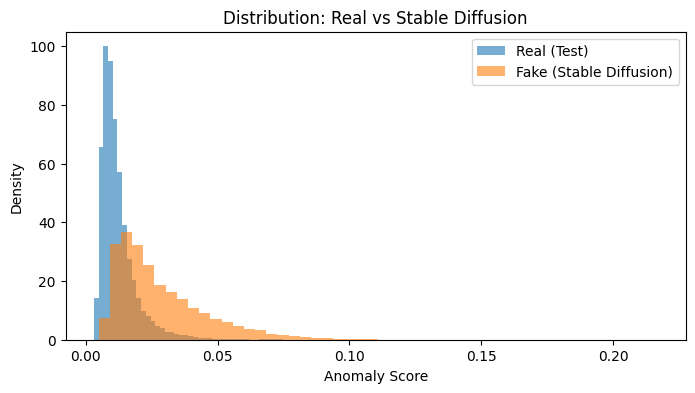

--- Processing: OpenJourney ---
   👉 AUC: 0.8937


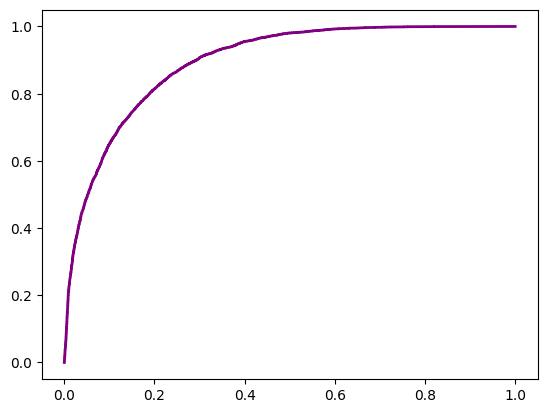

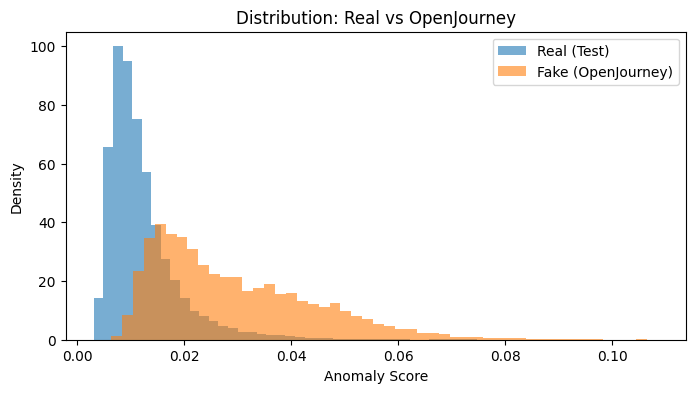

/tmp/ipython-input-4166644473.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


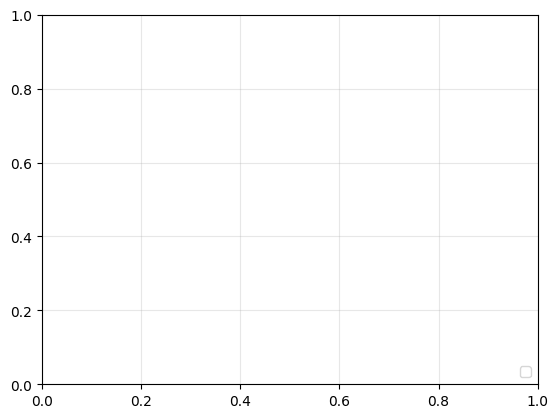


📊 FINAL THESIS RESULTS TABLE
Generator                      | AUC Score 
-------------------------------------------
DALL-E (GenImage)              | 0.9464
Stable Diffusion               | 0.8573
OpenJourney                    | 0.8937


In [13]:
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- CONFIGURATION ---
# DOUBLE CHECK THESE PATHS! If you are on Kaggle, use /kaggle/working/...
FAKE_DATASETS = {
    "DALL-E (GenImage)": "/content/test_fake_dalle.pt",
    "Stable Diffusion": "/content/test_fake_stablediffusion.pt",
    "OpenJourney": "/content/test_fake_openjourney.pt"
}

thesis_results = {}

print(f"⚡ STARTING VISUAL STRESS TEST ON {len(FAKE_DATASETS)} DATASETS\n")

# Ensure model is in eval mode
model.eval()

# 1. Create the Main ROC Figure explicitly
fig_roc = plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
plt.xlabel('False Positive Rate (FAR)')
plt.ylabel('True Positive Rate (TAR)')
plt.title('Cross-Generator Generalization (ROC Curves)')

colors = ['darkorange', 'green', 'purple', 'red', 'cyan']
color_idx = 0
valid_plot_count = 0

for name, path in FAKE_DATASETS.items():
    print(f"--- Processing: {name} ---")

    try:
        # Load Fake Data
        fake_tensor = torch.load(path).float()

        # Score Fake Data
        fake_scores = []
        with torch.no_grad():
            for batch in DataLoader(TensorDataset(fake_tensor), batch_size=BATCH_SIZE):
                s = get_anomaly_score(model, batch[0].to(DEVICE), c, ALPHA)
                fake_scores.append(s.cpu())
        fake_scores = torch.cat(fake_scores).numpy()

        # Metrics
        y_true = [0] * len(test_real_scores) + [1] * len(fake_scores)
        y_scores = np.concatenate([test_real_scores, fake_scores])

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        thesis_results[name] = roc_auc

        print(f"   👉 AUC: {roc_auc:.4f}")

        # --- PLOT 1: Add to Combined ROC (Targeting fig_roc) ---
        plt.figure(fig_roc.number) # Switch focus back to ROC figure
        plt.plot(fpr, tpr, lw=2, color=colors[color_idx % len(colors)],
                 label=f'{name} (AUC = {roc_auc:.4f})')
        color_idx += 1
        valid_plot_count += 1

        # --- PLOT 2: Individual Histogram ---
        # Create a new figure just for this histogram
        plt.figure(figsize=(8, 4))
        plt.hist(test_real_scores, bins=50, alpha=0.6, label='Real (Test)', density=True)
        plt.hist(fake_scores, bins=50, alpha=0.6, label=f'Fake ({name})', density=True)

        try:
            plt.axvline(threshold, color='red', linestyle='--', label='Threshold (FAR=5%)')
        except NameError:
            pass

        plt.title(f'Distribution: Real vs {name}')
        plt.xlabel('Anomaly Score')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

        # Cleanup
        del fake_tensor, fake_scores, y_true, y_scores, fpr, tpr
        gc.collect()
        torch.cuda.empty_cache()

    except FileNotFoundError:
        print(f"   ⚠️ File not found: {path} (Skipping)")
    except Exception as e:
        print(f"   ⚠️ Error processing {name}: {e}")

# --- FINALIZE COMBINED ROC ---
plt.figure(fig_roc.number) # Reactivate ROC figure
if valid_plot_count > 0:
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("\n❌ No data was plotted. Please check your file paths in FAKE_DATASETS.")
    plt.close()

# --- PRINT TABLE ---
if thesis_results:
    print("\n" + "="*40)
    print("📊 FINAL THESIS RESULTS TABLE")
    print("="*40)
    print(f"{'Generator':<30} | {'AUC Score':<10}")
    print("-" * 43)
    for name, score in thesis_results.items():
        print(f"{name:<30} | {score:.4f}")
    print("="*40)

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- CONFIGURATION ---
FAKE_DATASETS = {
    "DALL-E": "/content/test_fake_dalle.pt",
    "Stable Diffusion": "/content/test_fake_stablediffusion.pt",
    "OpenJourney": "/content/test_fake_openjourney.pt"
}

# Check if 'threshold' exists (from training cell). If not, define it manually or rerun training.
if 'threshold' not in locals():
    print("⚠️ Threshold variable not found. Please run the training/inference cell first!")
else:
    print(f"⚡ USING THRESHOLD: {threshold:.4f} (Derived from Real Validation Set)")

    # Setup the figure for side-by-side matrices
    n_datasets = len(FAKE_DATASETS)
    fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

    # Ensure axes is iterable if there's only one dataset
    if n_datasets == 1: axes = [axes]

    # Model to eval mode
    model.eval()

    for i, (name, path) in enumerate(FAKE_DATASETS.items()):
        print(f"Generating matrix for: {name}...")

        try:
            # 1. Load Fake Data
            fake_tensor = torch.load(path).float()

            # 2. Score Fake Data
            fake_scores = []
            with torch.no_grad():
                for batch in DataLoader(TensorDataset(fake_tensor), batch_size=BATCH_SIZE):
                    s = get_anomaly_score(model, batch[0].to(DEVICE), c, ALPHA)
                    fake_scores.append(s.cpu())
            fake_scores = torch.cat(fake_scores).numpy()

            # 3. Create Binary Labels & Predictions
            # Real Data (Class 0)
            real_true = [0] * len(test_real_scores)
            real_pred = (test_real_scores > threshold).astype(int) # 0=Real, 1=Fake prediction

            # Fake Data (Class 1)
            fake_true = [1] * len(fake_scores)
            fake_pred = (fake_scores > threshold).astype(int)      # 0=Real, 1=Fake prediction

            # Combine
            y_true = np.concatenate([real_true, fake_true])
            y_pred = np.concatenate([real_pred, fake_pred])

            # 4. Generate Matrix
            cm = confusion_matrix(y_true, y_pred)

            # 5. Plot
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
            disp.plot(cmap='Blues', ax=axes[i], values_format='d', colorbar=False)

            axes[i].set_title(f"{name}\n(Acc: {accuracy_score(y_true, y_pred):.2%})")

            # Cleanup
            del fake_tensor, fake_scores, y_true, y_pred
            gc.collect()

        except FileNotFoundError:
            axes[i].text(0.5, 0.5, "File Not Found", ha='center', va='center')
            print(f"⚠️ File not found: {path}")

    plt.tight_layout()
    plt.show()

⚠️ Threshold variable not found. Please run the training/inference cell first!
